In [1]:
import time
from pynq import Overlay
import numpy as np
from pynq import allocate
import cv2

def RunConv(conv,Kx,Ky,feature_in,W,bias,feature_out):
    conv.write(0x10,feature_in.shape[2])
    conv.write(0x18,feature_in.shape[0])
    conv.write(0x20,feature_in.shape[1])
    conv.write(0x28,feature_out.shape[2])
    conv.write(0x30,Kx)
    conv.write(0x38,Ky)
    conv.write(0x40,feature_in.physical_address)
    conv.write(0x4c,W.physical_address)
    conv.write(0x58,bias.physical_address)
    conv.write(0x64,feature_out.physical_address)
    conv.write(0, (conv.read(0)&0x80)|0x01)
    while not ((conv.read(0)>>1)&0x1):
        pass

def RunPool(pool,feature_in,feature_out):
    pool.write(0x10,feature_in.shape[2])
    pool.write(0x18,feature_in.shape[0])
    pool.write(0x20,feature_in.shape[1])
    pool.write(0x28,feature_in.physical_address)
    pool.write(0x34,feature_out.physical_address)
    pool.write(0, (pool.read(0)&0x80)|0x01)
    while not ((pool.read(0)>>1)&0x1):
        pass

def RunBn(bn,feature_in,W,bias,feature_out):
    bn.write(0x10,feature_in.shape[2])
    bn.write(0x18,feature_in.shape[0])
    bn.write(0x20,feature_in.shape[1])
    bn.write(0x28,feature_in.physical_address)
    bn.write(0x34,W.physical_address)
    bn.write(0x40,bias.physical_address)
    bn.write(0x4c,feature_out.physical_address)
    bn.write(0, (bn.read(0)&0x80)|0x01)
    while not ((bn.read(0)>>1)&0x1):
        pass

ol=Overlay("ip.bit")
#ol.ip_dict
ol.download()
conv=ol.Conv_0
pool=ol.Pool_0
bn=ol.Bn_0

print("Overlay download finish")

Overlay download finish


In [2]:
import os

def readbinfile(filename,size):
    z=[]
    print(filename)
    with open(filename, "r") as file:
        # 讀取每一行
        for line in file:
            # 將每一行轉換為整數
            number = float(line.strip())
            z.append(number)
            # 在這裡處理每一個數字
        z = np.array(z)
        return z
    
#input image
im_w = 94
im_c = 1
image=allocate(shape=(im_w,im_w,im_c),cacheable=0,dtype=np.float32)

#conv1
c1_w = im_w - 2
c1_cin = im_c
c1_cout = 16
p1_w = int(c1_w / 2)
W_conv1=allocate(shape=(3,3,c1_cin,c1_cout),cacheable=0,dtype=bool)
b_conv1=allocate(shape=(c1_cout),cacheable=0,dtype=np.float32)
h_conv1=allocate(shape=(c1_w,c1_w,c1_cout),cacheable=0,dtype=np.float32)
h_pool1=allocate(shape=(p1_w,p1_w,c1_cout),cacheable=0,dtype=np.float32)
W_bn1=allocate(shape=(c1_cout),cacheable=0,dtype=np.float32)
b_bn1=allocate(shape=(c1_cout),cacheable=0,dtype=np.float32)
h_bn1=allocate(shape=(p1_w,p1_w,c1_cout),cacheable=0,dtype=np.float32)

#conv2
c2_w = p1_w - 2
c2_cin = c1_cout
c2_cout = 32
p2_w = int(c2_w / 2)
W_conv2=allocate(shape=(3,3,c2_cin,c2_cout),cacheable=0,dtype=bool)
b_conv2=allocate(shape=(c2_cout),cacheable=0,dtype=np.float32)
h_conv2=allocate(shape=(c2_w,c2_w,c2_cout),cacheable=0,dtype=np.float32)
h_pool2=allocate(shape=(p2_w,p2_w,c2_cout),cacheable=0,dtype=np.float32)
W_bn2=allocate(shape=(c2_cout),cacheable=0,dtype=np.float32)
b_bn2=allocate(shape=(c2_cout),cacheable=0,dtype=np.float32)
h_bn2=allocate(shape=(p2_w,p2_w,c2_cout),cacheable=0,dtype=np.float32)

#conv3
c3_w = p2_w - 2
c3_cin = c2_cout
c3_cout = 64
p3_w = int(c3_w / 2)
W_conv3=allocate(shape=(3,3,c3_cin,c3_cout),cacheable=0,dtype=bool)
b_conv3=allocate(shape=(c3_cout),cacheable=0,dtype=np.float32)
h_conv3=allocate(shape=(c3_w,c3_w,c3_cout),cacheable=0,dtype=np.float32)
h_pool3=allocate(shape=(p3_w,p3_w,c3_cout),cacheable=0,dtype=np.float32)
W_bn3=allocate(shape=(c3_cout),cacheable=0,dtype=np.float32)
b_bn3=allocate(shape=(c3_cout),cacheable=0,dtype=np.float32)
h_bn3=allocate(shape=(p3_w,p3_w,c3_cout),cacheable=0,dtype=np.float32)

#conv4
c4_w = p3_w - 2
c4_cin = c3_cout
c4_cout = 64
p4_w = int(c4_w / 2)
W_conv4=allocate(shape=(3,3,c4_cin,c4_cout),cacheable=0,dtype=bool)
b_conv4=allocate(shape=(c4_cout),cacheable=0,dtype=np.float32)
h_conv4=allocate(shape=(c4_w,c4_w,c4_cout),cacheable=0,dtype=np.float32)
h_pool4=allocate(shape=(p4_w,p4_w,c4_cout),cacheable=0,dtype=np.float32)
W_bn4=allocate(shape=(c4_cout),cacheable=0,dtype=np.float32)
b_bn4=allocate(shape=(c4_cout),cacheable=0,dtype=np.float32)
h_bn4=allocate(shape=(p4_w,p4_w,c4_cout),cacheable=0,dtype=np.float32)

#conv5
c5_w = p4_w - 2
c5_cin = c4_cout
c5_cout = 64
p5_w = int(c5_w / 2)
W_conv5=allocate(shape=(3,3,c5_cin,c5_cout),cacheable=0,dtype=bool)
b_conv5=allocate(shape=(c5_cout),cacheable=0,dtype=np.float32)
h_conv5=allocate(shape=(c5_w,c5_w,c5_cout),cacheable=0,dtype=np.float32)
h_pool5=allocate(shape=(p5_w,p5_w,c5_cout),cacheable=0,dtype=np.float32)
W_bn5=allocate(shape=(c5_cout),cacheable=0,dtype=np.float32)
b_bn5=allocate(shape=(c5_cout),cacheable=0,dtype=np.float32)
h_bn5=allocate(shape=(p5_w,p5_w,c5_cout),cacheable=0,dtype=np.float32)

#fc1
f1_w = p5_w
f1_cin = c4_cout
f1_cout = 32
W_fc1=allocate(shape=(1, 1, f1_cin, f1_cout),cacheable=0,dtype=bool)
b_fc1=allocate(shape=(f1_cout),cacheable=0,dtype=np.float32)
h_fc1=allocate(shape=(f1_w,f1_w,f1_cout),cacheable=0,dtype=np.float32)
W_bn6=allocate(shape=(f1_cout),cacheable=0,dtype=np.float32)
b_bn6=allocate(shape=(f1_cout),cacheable=0,dtype=np.float32)
h_bn6=allocate(shape=(f1_w,f1_w,f1_cout),cacheable=0,dtype=np.float32)

#fc2
f2_w = f1_w
f2_cin = f1_cout
f2_cout = 10
W_fc2=allocate(shape=(1, 1, f2_cin, f2_cout),cacheable=0,dtype=bool)
b_fc2=allocate(shape=(f2_cout),cacheable=0,dtype=np.float32)
h_fc2=allocate(shape=(f2_w,f2_w,f2_cout),cacheable=0,dtype=np.float32)

#Initialize W, bias
w_conv1=readbinfile("weight/W_quant_conv2d.bin",3*3*c1_cin*c1_cout)
w_conv1=w_conv1.reshape((3,3,c1_cin,c1_cout))
for i in range(3):
    for j in range(3):
        for k in range(c1_cin):
            for l in range(c1_cout):
                if w_conv1[i][j][k][l] == 1:
                    W_conv1[i][j][k][l] = 1
                else:
                    W_conv1[i][j][k][l] = 0
B_conv1=readbinfile("weight/b_quant_conv2d.bin",c1_cout)
w_bn1=readbinfile("weight/W_batch_normalization.bin",c1_cout)
B_bn1=readbinfile("weight/b_batch_normalization.bin",c1_cout)
for i in range(c1_cout):
    b_conv1[i]=B_conv1[i]
    W_bn1[i]=w_bn1[i]
    b_bn1[i]=B_bn1[i]

w_conv2=readbinfile("weight/W_quant_conv2d_1.bin",3*3*c2_cin*c2_cout)
w_conv2=w_conv2.reshape((3,3,c2_cin,c2_cout))
for i in range(3):
    for j in range(3):
        for k in range(c2_cin):
            for l in range(c2_cout):
                if w_conv2[i][j][k][l] == 1:
                    W_conv2[i][j][k][l] = 1
                else:
                    W_conv2[i][j][k][l] = 0
B_conv2=readbinfile("weight/b_quant_conv2d_1.bin",c2_cout)
w_bn2=readbinfile("weight/W_batch_normalization_1.bin",c2_cout)
B_bn2=readbinfile("weight/b_batch_normalization_1.bin",c2_cout)
for i in range(c2_cout):
    b_conv2[i]=B_conv2[i]
    W_bn2[i]=w_bn2[i]
    b_bn2[i]=B_bn2[i]
    
w_conv3=readbinfile("weight/W_quant_conv2d_2.bin",3*3*c3_cin*c3_cout)
w_conv3=w_conv3.reshape((3,3,c3_cin,c3_cout))
for i in range(3):
    for j in range(3):
        for k in range(c3_cin):
            for l in range(c3_cout):
                if w_conv3[i][j][k][l] == 1:
                    W_conv3[i][j][k][l] = 1
                else:
                    W_conv3[i][j][k][l] = 0
B_conv3=readbinfile("weight/b_quant_conv2d_2.bin",c3_cout)
w_bn3=readbinfile("weight/W_batch_normalization_2.bin",c3_cout)
B_bn3=readbinfile("weight/b_batch_normalization_2.bin",c3_cout)
for i in range(c3_cout):
    b_conv3[i]=B_conv3[i]
    W_bn3[i]=w_bn3[i]
    b_bn3[i]=B_bn3[i]

w_conv4=readbinfile("weight/W_quant_conv2d_3.bin",3*3*c4_cin*c4_cout)
w_conv4=w_conv4.reshape((3,3,c4_cin,c4_cout))
for i in range(3):
    for j in range(3):
        for k in range(c4_cin):
            for l in range(c4_cout):
                if w_conv4[i][j][k][l] == 1:
                    W_conv4[i][j][k][l] = 1
                else:
                    W_conv4[i][j][k][l] = 0
B_conv4=readbinfile("weight/b_quant_conv2d_3.bin",c4_cout)
w_bn4=readbinfile("weight/W_batch_normalization_3.bin",c4_cout)
B_bn4=readbinfile("weight/b_batch_normalization_3.bin",c4_cout)
for i in range(c4_cout):
    b_conv4[i]=B_conv4[i]
    W_bn4[i]=w_bn4[i]
    b_bn4[i]=B_bn4[i]
    
w_conv5=readbinfile("weight/W_quant_conv2d_4.bin",3*3*c5_cin*c5_cout)
w_conv5=w_conv5.reshape((3,3,c5_cin,c5_cout))
for i in range(3):
    for j in range(3):
        for k in range(c5_cin):
            for l in range(c5_cout):
                if w_conv5[i][j][k][l] == 1:
                    W_conv5[i][j][k][l] = 1
                else:
                    W_conv5[i][j][k][l] = 0
B_conv5=readbinfile("weight/b_quant_conv2d_4.bin",c5_cout)
w_bn5=readbinfile("weight/W_batch_normalization_4.bin",c5_cout)
B_bn5=readbinfile("weight/b_batch_normalization_4.bin",c5_cout)
for i in range(c5_cout):
    b_conv5[i]=B_conv5[i]
    W_bn5[i]=w_bn5[i]
    b_bn5[i]=B_bn5[i]

w_fc1=readbinfile("weight/W_quant_conv2d_5.bin",1*1*f1_cin*f1_cout)
w_fc1=w_fc1.reshape((1,1,f1_cin,f1_cout))
for i in range(1):
    for j in range(1):
        for k in range(f1_cin):
            for l in range(f1_cout):
                if w_fc1[i][j][k][l] == 1:
                    W_fc1[i][j][k][l] = 1
                else:
                    W_fc1[i][j][k][l] = 0
B_fc1=readbinfile("weight/b_quant_conv2d_5.bin",f1_cout)
w_bn6=readbinfile("weight/W_batch_normalization_5.bin",f1_cout)
B_bn6=readbinfile("weight/b_batch_normalization_5.bin",f1_cout)
for i in range(f1_cout):
    b_fc1[i]=B_fc1[i]
    W_bn6[i]=w_bn6[i]
    b_bn6[i]=B_bn6[i]
    
w_fc2=readbinfile("weight/W_quant_conv2d_6.bin",1*1*f2_cin*f2_cout)
w_fc2=w_fc2.reshape((1,1,f2_cin,f2_cout))
for i in range(1):
    for j in range(1):
        for k in range(f2_cin):
            for l in range(f2_cout):
                if w_fc2[i][j][k][l] == 1:
                    W_fc2[i][j][k][l] = 1
                else:
                    W_fc2[i][j][k][l] = 0
B_fc2=readbinfile("weight/b_quant_conv2d_6.bin",f2_cout)
for i in range(f2_cout):
    b_fc2[i]=B_fc2[i]

print("Finish initial")

weight/W_quant_conv2d.bin
weight/b_quant_conv2d.bin
weight/W_batch_normalization.bin
weight/b_batch_normalization.bin
weight/W_quant_conv2d_1.bin
weight/b_quant_conv2d_1.bin
weight/W_batch_normalization_1.bin
weight/b_batch_normalization_1.bin
weight/W_quant_conv2d_2.bin
weight/b_quant_conv2d_2.bin
weight/W_batch_normalization_2.bin
weight/b_batch_normalization_2.bin
weight/W_quant_conv2d_3.bin
weight/b_quant_conv2d_3.bin
weight/W_batch_normalization_3.bin
weight/b_batch_normalization_3.bin
weight/W_quant_conv2d_4.bin
weight/b_quant_conv2d_4.bin
weight/W_batch_normalization_4.bin
weight/b_batch_normalization_4.bin
weight/W_quant_conv2d_5.bin
weight/b_quant_conv2d_5.bin
weight/W_batch_normalization_5.bin
weight/b_batch_normalization_5.bin
weight/W_quant_conv2d_6.bin
weight/b_quant_conv2d_6.bin
Finish initial


Run time: 9.145456790924072
Prediction of pic 1 is 0


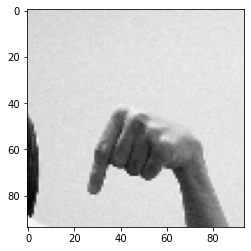

In [3]:
import time
from matplotlib import pyplot as plt

for count in range(1, 2):
    image1=cv2.imread("pic/down/{}.jpg".format(count),cv2.IMREAD_GRAYSCALE).astype(np.float32)
    image1=cv2.resize(image1, (im_w,im_w))
    image1=image1.reshape((im_w,im_w,1))
    for i in range(im_w):
        for j in range(im_w):
            for k in range(1):
                image[i][j][k]=image1[i][j][k]/255
    ctime = time.time()
    #conv1
    RunConv(conv, 3, 3, image, W_conv1, b_conv1, h_conv1)
    RunPool(pool, h_conv1, h_pool1)
    RunBn(bn, h_pool1, W_bn1, b_bn1, h_bn1)
    #conv2
    RunConv(conv, 3, 3, h_bn1, W_conv2, b_conv2, h_conv2)
    RunPool(pool, h_conv2, h_pool2)
    RunBn(bn, h_pool2, W_bn2, b_bn2, h_bn2)
    #conv3
    RunConv(conv, 3, 3, h_bn2, W_conv3, b_conv3, h_conv3)
    RunPool(pool, h_conv3, h_pool3)
    RunBn(bn, h_pool3, W_bn3, b_bn3, h_bn3)
    #conv4
    RunConv(conv, 3, 3, h_bn3, W_conv4, b_conv4, h_conv4)
    RunPool(pool, h_conv4, h_pool4)
    RunBn(bn, h_pool4, W_bn4, b_bn4, h_bn4)
    #conv5
    RunConv(conv, 3, 3, h_bn4, W_conv5, b_conv5, h_conv5)
    RunPool(pool, h_conv5, h_pool5)
    RunBn(bn, h_pool5, W_bn5, b_bn5, h_bn5)
    #fc1
    RunConv(conv, 1, 1, h_bn5, W_fc1, b_fc1,h_fc1)
    RunBn(bn, h_fc1, W_bn6, b_bn6, h_bn6)
    #fc2
    RunConv(conv, 1, 1, h_bn6, W_fc2, b_fc2,h_fc2)
    ptime = time.time()
    MAX = h_fc2[0][0][0]
    #print(MAX)
    result=0
    for j in range(10):
        #print(h_fc2[0][0][j])
        if(h_fc2[0][0][j]>MAX):
            MAX=h_fc2[0][0][j]
            result=j

    print("Run time: {}".format(ptime-ctime))
    print("Prediction of pic {} is ".format(count)+str(result))
    plt.imshow(image, plt.get_cmap('gray'))
    plt.show()

In [4]:
print('W_conv1',np.shape(W_conv1))
print('b_conv1',np.shape(b_conv1))
print('W_bn1',np.shape(W_bn1))
print('b_bn1',np.shape(b_bn1))

print('W_conv2',np.shape(W_conv2))
print('b_conv2',np.shape(b_conv2))
print('W_bn2',np.shape(W_bn2))
print('b_bn2',np.shape(b_bn2))

print('W_conv3',np.shape(W_conv3))
print('b_conv3',np.shape(b_conv3))
print('W_bn3',np.shape(W_bn3))
print('b_bn3',np.shape(b_bn3))

print('W_conv4',np.shape(W_conv4))
print('b_conv4',np.shape(b_conv4))
print('W_bn4',np.shape(W_bn4))
print('b_bn4',np.shape(b_bn4))

print('W_conv5',np.shape(W_conv5))
print('b_conv5',np.shape(b_conv5))
print('W_bn5',np.shape(W_bn5))
print('b_bn5',np.shape(b_bn5))

print('W_fc1',np.shape(W_fc1))
print('b_fc1',np.shape(b_fc1))
print('W_bn6',np.shape(W_bn6))
print('b_bn6',np.shape(b_bn6))

print('W_fc2',np.shape(W_fc2))
print('b_fc2',np.shape(b_fc2))

print('h_conv1',np.shape(h_conv1))
print('h_pool1',np.shape(h_pool1))
print('h_bn1',np.shape(h_bn1))
print('h_conv2',np.shape(h_conv2))
print('h_pool2',np.shape(h_pool2))
print('h_bn2',np.shape(h_bn2))
print('h_conv3',np.shape(h_conv3))
print('h_pool3',np.shape(h_pool3))
print('h_bn33',np.shape(h_bn3))
print('h_conv4',np.shape(h_conv4))
print('h_pool4',np.shape(h_pool4))
print('h_bn4',np.shape(h_bn4))
print('h_conv5',np.shape(h_conv5))
print('h_pool5',np.shape(h_pool5))
print('h_bn5',np.shape(h_bn5))
print('h_fc1',np.shape(h_fc1))
print('h_bn6',np.shape(h_bn6))
print('h_fc2',np.shape(h_fc2))

W_conv1 (3, 3, 1, 16)
b_conv1 (16,)
W_bn1 (16,)
b_bn1 (16,)
W_conv2 (3, 3, 16, 32)
b_conv2 (32,)
W_bn2 (32,)
b_bn2 (32,)
W_conv3 (3, 3, 32, 64)
b_conv3 (64,)
W_bn3 (64,)
b_bn3 (64,)
W_conv4 (3, 3, 64, 64)
b_conv4 (64,)
W_bn4 (64,)
b_bn4 (64,)
W_conv5 (3, 3, 64, 64)
b_conv5 (64,)
W_bn5 (64,)
b_bn5 (64,)
W_fc1 (1, 1, 64, 32)
b_fc1 (32,)
W_bn6 (32,)
b_bn6 (32,)
W_fc2 (1, 1, 32, 10)
b_fc2 (10,)
h_conv1 (92, 92, 16)
h_pool1 (46, 46, 16)
h_bn1 (46, 46, 16)
h_conv2 (44, 44, 32)
h_pool2 (22, 22, 32)
h_bn2 (22, 22, 32)
h_conv3 (20, 20, 64)
h_pool3 (10, 10, 64)
h_bn33 (10, 10, 64)
h_conv4 (8, 8, 64)
h_pool4 (4, 4, 64)
h_bn4 (4, 4, 64)
h_conv5 (2, 2, 64)
h_pool5 (1, 1, 64)
h_bn5 (1, 1, 64)
h_fc1 (1, 1, 32)
h_bn6 (1, 1, 32)
h_fc2 (1, 1, 10)


In [5]:
print(h_conv1)

[[[ 1.8907471  -0.6308378   0.57249606 ... -1.8391258   1.8481419
   -3.0651014 ]
  [ 1.8814781  -0.6447636   0.61004615 ... -1.922372    1.8997109
   -3.0990102 ]
  [ 1.8612368  -0.6475954   0.5657562  ... -1.841873    1.8192127
   -3.1238928 ]
  ...
  [ 1.9866747  -0.66114867  0.62287813 ... -1.9642822   1.9495378
   -3.256819  ]
  [ 1.9833735  -0.67237467  0.599552   ... -1.9695851   1.9333845
   -3.277365  ]
  [ 2.0170527  -0.69645846  0.6212542  ... -1.9650124   1.9778283
   -3.2726812 ]]

 [[ 1.8894444  -0.65010613  0.6116055  ... -1.8744434   1.8368533
   -3.1475294 ]
  [ 1.858901   -0.674375    0.58423555 ... -1.805817    1.820411
   -3.107259  ]
  [ 1.8801234  -0.61748743  0.57951057 ... -1.8265129   1.8172901
   -3.0786188 ]
  ...
  [ 1.9836438  -0.6665815   0.6105022  ... -1.9592507   1.9515553
   -3.2640038 ]
  [ 1.9901481  -0.6715165   0.6118299  ... -1.9676758   1.9741399
   -3.2881107 ]
  [ 2.0042171  -0.6871274   0.6169746  ... -1.9832095   1.9808466
   -3.3267248 ]]

 

In [6]:
h_pool1

PynqBuffer([[[ 1.8907471 , -0.6308378 ,  0.6116055 , ..., -1.805817  ,
               1.8997109 , -3.0651014 ],
             [ 1.8801234 , -0.61748743,  0.57951057, ..., -1.8265129 ,
               1.8711238 , -3.0666397 ],
             [ 1.9135083 , -0.59297305,  0.6110509 , ..., -1.8408482 ,
               1.8677377 , -3.0844448 ],
             ...,
             [ 2.0189285 , -0.6701986 ,  0.66156304, ..., -1.9483995 ,
               2.0006843 , -3.258609  ],
             [ 1.9866747 , -0.66114867,  0.62287813, ..., -1.9306248 ,
               1.9572616 , -3.2498572 ],
             [ 2.0170527 , -0.6715165 ,  0.6212542 , ..., -1.9650124 ,
               1.9808466 , -3.2726812 ]],

            [[ 1.890965  , -0.59909755,  0.5975709 , ..., -1.8456496 ,
               1.8711495 , -3.0329058 ],
             [ 1.8847841 , -0.6049021 ,  0.5979783 , ..., -1.8399743 ,
               1.8788111 , -3.0760815 ],
             [ 1.8926609 , -0.60498303,  0.6168921 , ..., -1.819249  ,
             

In [7]:
h_bn1

PynqBuffer([[[ 0.29873776, -0.7511624 ,  0.14810562, ..., -0.24587345,
               0.7354257 , -0.5478232 ],
             [ 0.280339  , -0.7064532 ,  0.03431726, ..., -0.280267  ,
               0.6782253 , -0.5492468 ],
             [ 0.33815718, -0.62435687,  0.14613938, ..., -0.30409002,
               0.6714499 , -0.5657244 ],
             ...,
             [ 0.52073145, -0.8829783 ,  0.32522345, ..., -0.48282456,
               0.9374647 , -0.72690225],
             [ 0.46487188, -0.8526708 ,  0.18807125, ..., -0.4532857 ,
               0.85057974, -0.7188029 ],
             [ 0.5174825 , -0.8873917 ,  0.18231392, ..., -0.5104327 ,
               0.89777136, -0.73992515]],

            [[ 0.29911518, -0.6448673 ,  0.0983479 , ..., -0.31206918,
               0.6782768 , -0.51802826],
             [ 0.28841066, -0.66430604,  0.09979224, ..., -0.30263782,
               0.6936071 , -0.5579846 ],
             [ 0.30205226, -0.6645771 ,  0.16684866, ..., -0.2681954 ,
             